#Perfoming K-Nearest Neighbours on Amazon Fine Food Reviews

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews 

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews : 568,454

Number of products : 74,258

Timespan : Oct 1999 - Oct 2012

Number of Attributes/Columns in data : 10

###Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

###Objective:

Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

##1. Reading Data

###1.1. Loading Data

The dataset is available in two forms

1. csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently. 
Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import sklearn
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.model_selection import cross_validate

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#lists the content of your google drive
!ls "/content/drive/My Drive/datasets/amazon fine food"


database.sqlite


In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/datasets/amazon fine food/database.sqlite') 

# filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3
# for this analysis we are only taking 50000 data points considering our computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

##2. Exploratory Data Analysis

###2.1. Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

###Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

##3. Preprocessing 

###3.1. Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [17]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
nltk.download("stopwords")

In [20]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)


{'y', 'its', 'other', 's', 'm', 'does', 'than', 'on', 'they', 'you', "shan't", 'again', 'no', "weren't", 'we', 'this', 'as', 'i', 'are', 'haven', 'about', 'there', 'at', "should've", 'wasn', 'during', 'themselves', "aren't", 'an', 'mustn', "couldn't", 'through', 've', 'out', 'being', 'ours', 'd', "you're", 'my', "she's", "haven't", 'for', 'too', 'same', 'who', 'itself', 'doing', 'nor', 'once', 'don', 'our', 'do', 'why', 'those', 'the', "you've", 'yourself', 'ain', 'over', 'wouldn', 'few', 'above', 'didn', 'any', 'theirs', 'having', 'is', 'how', "wouldn't", 'weren', 'he', 'after', 'what', "hadn't", 'which', 'aren', 'his', 'so', 'herself', 'myself', 'were', 'when', "didn't", 'hasn', "won't", 'them', "that'll", 'of', 'doesn', "isn't", 'and', 'before', 'was', "hasn't", 'or', 'himself', 'to', 'will', 'been', 'needn', 'very', 'hers', 'yours', 'o', 'these', 'while', 'by', 'between', 'all', 'ourselves', 'into', 'against', 'where', 'most', 'here', 'mightn', "mustn't", 'whom', "wasn't", 'below',

In [21]:
# Combining all the above stundents 
from tqdm import tqdm

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|██████████| 46071/46071 [01:10<00:00, 651.24it/s]


In [0]:
#after data suplication and preprocessing we are adding the CleanedText as a new attribute of our dataset
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [23]:
final.shape

(46071, 11)

In [0]:
#sorting the dataset by time so that we can later perform time-based splitting of the dataset into train and test
final = final.sort_values(by=['Time'], axis=0) 
score = final['Score'].values
text = final['CleanedText'].values

In [0]:
#splitting the dataset into train, test and cross validate 
x_train, x_test, y_train, y_test = train_test_split(text, score, test_size=0.3, shuffle=False)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.3, shuffle=False)

In [26]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_cv.shape, y_cv.shape)

(22574,) (22574,)
(13822,) (13822,)
(9675,) (9675,)


In [28]:
print("Number of positive(1) and negative(0) datapoints in our train dataset")
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

Number of positive(1) and negative(0) datapoints in our train dataset


{0: 3339, 1: 19235}

In [0]:
printf("Number of positive(1) and negative(0) datapoints in our test dataset")
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 2529, 1: 11293}

In [0]:
printf("Number of positive(1) and negative(0) datapoints in our cross validate dataset")
unique, counts = np.unique(y_cv, return_counts=True)
dict(zip(unique, counts))

{0: 1724, 1: 7951}

##4. KNN Brute Force

###4.1.  KNN brute force on Bag Of Words (BOW) 

In [0]:
#coveting text to vectors using BOW 
#will be coverting train, test and cross validate datasets seperately to overcome data leakage problem

count_vect = CountVectorizer() #in scikit-learn

#converting train data to vectors using BOW
bow_x_train = count_vect.fit_transform(x_train) 
bow_x_train.shape

(22574, 18111)

In [0]:
#converting test data to vectors using BOW
bow_x_test = count_vect.transform(x_test)
bow_x_test.shape

(13822, 18111)

In [0]:
#converting cross validate data to vectors using BOW
bow_x_cv = count_vect.transform(x_cv)
bow_x_cv.shape

(9675, 18111)

In [0]:
klist = list(range(1,30,2))
klist

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

100%|██████████| 15/15 [04:13<00:00, 17.36s/it]


9


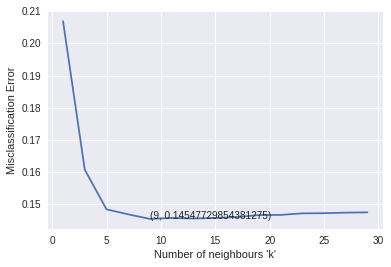

In [0]:
cv_scores = [] #list to keep cross validate score
for k in tqdm(klist):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn, bow_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1) #cv = 10 to perform 10 fold cross validation 
    cv_scores.append(scores.mean())

#calculating Mssclassification error    
error = [1 - x for x in cv_scores]

#determing optimal k with least missclassification error value
optimal_k = klist[error.index(min(error))]
print(optimal_k)

#graph between missclassification error and hyperparameter values 
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()


In [0]:
#applying KNN on the optimal K calculated (9)

#initiate model
neigh = KNeighborsClassifier(n_neighbors= optimal_k)

#fit model
neigh.fit(bow_x_train, y_train)

#predicting values for test data
y_test_pred =  neigh.predict(bow_x_test)

#calculating accuracy of model
train_acc = neigh.score(bow_x_train, y_train) #train accuracy
train_error = 1 - train_acc #train error
test_acc = accuracy_score(y_test, y_test_pred) #test accuracy
test_error = 1 - test_acc #test error

print("_" * 101)
print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)
print("_" * 101)

print("="*100)

#evaluating confusion matrix for train and test
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(bow_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(bow_x_test)))

_____________________________________________________________________________________________________
Training Accuracy:  0.8673252414281917
Train Error:  0.13267475857180833
Test Accuracy:  0.8215164230936188
Test Error:  0.17848357690638117
_____________________________________________________________________________________________________
Train confusion matrix
[[  421  2918]
 [   77 19158]]
Test confusion matrix
[[  138  2391]
 [   76 11217]]


####Observation :
1. Optimal Hyperparaneter = 9 
2. Training Accuracy = 86.73252414281917 %
3. Test Accuracy = 82.15164230936188 %

### 4.2 KNN brute force on TF-IDF

In [0]:
#coveting text to vectors using tf-idf 

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

#converting train data to vectors using tf-idf
tf_idf_x_train = tf_idf_vect.fit_transform(x_train)
tf_idf_x_train.shape

(22574, 424349)

In [0]:
#converting test data to vectors using tf-idf
tf_idf_x_test = tf_idf_vect.transform(x_test)
tf_idf_x_test.shape

(13822, 424349)

In [0]:
#converting cross validate data to vectors using tf-idf
tf_idf_x_cv = tf_idf_vect.transform(x_cv)
tf_idf_x_cv.shape

(9675, 424349)

100%|██████████| 15/15 [04:37<00:00, 17.83s/it]


9


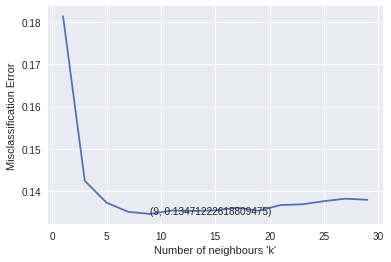

In [0]:
cv_scores = [] #list to keep cross validate score
for k in tqdm(klist):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn, tf_idf_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

#calculating Mssclassification error    
error = [1 - x for x in cv_scores]

#determing optimal k with least missclassification error value
optimal_k = klist[error.index(min(error))]
print(optimal_k)

#determing optimal k with least missclassification error value
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [0]:
#applying KNN on the optimal K calculated (9)

#initiate model
knn_tf_idf = KNeighborsClassifier(n_neighbors= optimal_k)

#fit model
knn_tf_idf.fit(tf_idf_x_train, y_train)

#predicting values for test data
y_test_pred =  knn_tf_idf.predict(tf_idf_x_test)

#calculating accuracy of model
train_acc = knn_tf_idf.score(tf_idf_x_train, y_train) #train accuracy
train_error = 1 - train_acc #train error
test_acc = accuracy_score(y_test, y_test_pred) #test accuracy
test_error = 1 - test_acc #test error

print("_" * 101)
print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)
print("_" * 101)


from sklearn.metrics import confusion_matrix

#evaluating confusion matrix for train and test
print("Train confusion matrix")
print(confusion_matrix(y_train, knn_tf_idf.predict(tf_idf_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, knn_tf_idf.predict(tf_idf_x_test)))

_____________________________________________________________________________________________________
Training Accuracy:  0.8812793479223886
Train Error:  0.1187206520776114
Test Accuracy:  0.8356243669512372
Test Error:  0.1643756330487628
_____________________________________________________________________________________________________
Train confusion matrix
[[  784  2555]
 [  125 19110]]
Test confusion matrix
[[  370  2159]
 [  113 11180]]


####Observation :
1. Optimal Hyperparaneter = 9 
2. Training Accuracy = 88.12793479223886 %
3. Test Accuracy = 83.56243669512372 %

###4.3. KNN brute force on average W2V

In [0]:
#coveting text to vectors using avg w2v

#coveting train data to vectors using avg w2v 
i=0
list_of_sent_train=[]
for sent in x_train:
    list_of_sent_train.append(sent.split())
    
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_x_train = Word2Vec(list_of_sent_train,min_count=5,size=50, workers=2)

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_x_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
avg_w2v_x_train = np.array(sent_vectors)
avg_w2v_x_train.shape

(22574, 50)

In [0]:
#coveting test data to vectors using avg w2v
i=0
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())
    
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_x_test = Word2Vec(list_of_sent_test,min_count=5,size=50, workers=2)

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_x_test.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
avg_w2v_x_test = np.array(sent_vectors)
avg_w2v_x_test.shape

(13822, 50)

In [0]:
#coveting cross validate data to vectors using w2v 
i=0
list_of_sent_cv=[]
for sent in x_cv:
    list_of_sent_cv.append(sent.split())
    
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_x_cv = Word2Vec(list_of_sent_cv,min_count=5,size=50, workers=2)

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_x_cv.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
avg_w2v_x_cv = np.array(sent_vectors)
avg_w2v_x_cv.shape

(9675, 50)

100%|██████████| 15/15 [08:19<00:00, 34.53s/it]


25


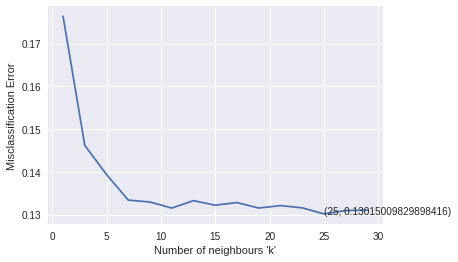

In [0]:
cv_scores = [] #list to keep cross validate score
for k in tqdm(klist):
    knn_avg_w2v = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn_avg_w2v, avg_w2v_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

#calculating Mssclassification error
error = [1 - x for x in cv_scores]

#determing optimal k with least missclassification error value
optimal_k = klist[error.index(min(error))]
print(optimal_k)

#determing optimal k with least missclassification error value
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [0]:
#applying KNN on the optimal K calculated (25)

#initiate model
knn_avg_w2v = KNeighborsClassifier(n_neighbors= optimal_k)

#fit model
knn_avg_w2v.fit(avg_w2v_x_train, y_train)

#predicting values for test data
y_test_pred =  knn_avg_w2v.predict(avg_w2v_x_test)

#calculating accuracy of model
train_acc = knn_avg_w2v.score(avg_w2v_x_train, y_train)
train_error = 1 - train_acc
test_acc = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_acc

print("_" * 101)
print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)
print("_" * 101)


from sklearn.metrics import confusion_matrix

#evaluating confusion matrix for train and test
print("Train confusion matrix")
print(confusion_matrix(y_train, knn_avg_w2v.predict(avg_w2v_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, knn_avg_w2v.predict(avg_w2v_x_test)))

_____________________________________________________________________________________________________
Training Accuracy:  0.8756091078231594
Train Error:  0.12439089217684063
Test Accuracy:  0.8207205903631891
Test Error:  0.17927940963681088
_____________________________________________________________________________________________________
Train confusion matrix
[[  732  2607]
 [  201 19034]]
Test confusion matrix
[[  114  2415]
 [   63 11230]]


####Observation :
1. Optimal Hyperparaneter = 25 
2. Training Accuracy = 87.56091078231594 %
3. Test Accuracy = 82.07205903631891 %

##5. KNN KD Tree

###5.1. KNN KD Tree on Bag of Words (BOW)

In [0]:
#coveting text to vectors using BOW 
#keeping maximum limit on number of features to 500

count_vect = CountVectorizer(min_df=10, max_features=500)

#converting train data to vectors using BOW
bow_x_train = count_vect.fit_transform(x_train)
bow_x_train.shape  

(22574, 500)

In [0]:
#converting test data to vectors using BOW
bow_x_test = count_vect.transform(x_test)
bow_x_test.shape

(13822, 500)

In [0]:
#converting cross validate data to vectors using BOW
bow_x_cv = count_vect.transform(x_cv)
bow_x_cv.shape

(9675, 500)

100%|██████████| 15/15 [04:29<00:00, 17.94s/it]


11


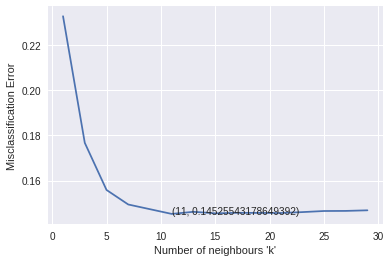

In [0]:
cv_scores = [] #list to keep cross validate score
for k in tqdm(klist):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree', n_jobs=-1)
    scores = cross_val_score(knn, bow_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

#calculating Mssclassification error    
error = [1 - x for x in cv_scores]

#determing optimal k with least missclassification error value
optimal_k = klist[error.index(min(error))]
print(optimal_k)

#graph between missclassification error and hyperparameter values
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [0]:
#applying KNN on the optimal K calculated (11)

#initiate model
knn_kd_bow = KNeighborsClassifier(n_neighbors= optimal_k, algorithm='kd_tree')

#fit model
knn_kd_bow.fit(bow_x_train, y_train)

#predicting values for test data
y_test_pred =  knn_kd_bow.predict(bow_x_test)

#calculating accuracy of model
train_acc = knn_kd_bow.score(bow_x_train, y_train)
train_error = 1 - train_acc
test_acc = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_acc

print("_" * 101)
print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)
print("_" * 101)


from sklearn.metrics import confusion_matrix

#evaluating confusion matrix for train and test
print("Train confusion matrix")
print(confusion_matrix(y_train, knn_kd_bow.predict(bow_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, knn_kd_bow.predict(bow_x_test)))

_____________________________________________________________________________________________________
Training Accuracy:  0.8625409763444671
Train Error:  0.13745902365553286
Test Accuracy:  0.8223122558240487
Test Error:  0.17768774417595135
_____________________________________________________________________________________________________
Train confusion matrix
[[  309  3030]
 [   73 19162]]
Test confusion matrix
[[  147  2382]
 [   74 11219]]


####Observation :
1. Optimal Hyperparaneter = 11 
2. Training Accuracy = 86.25409763444671 %
3. Test Accuracy = 82.23122558240487 %

###5.2 KNN KD Tree on TF-IDF

In [0]:
#coveting text to vectors using tf-idf
#keeping maximum limit on number of features to 500

tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)

#converting train data to vectors using tf-idf
tf_idf_x_train =  tf_idf_vect.fit_transform(x_train)
tf_idf_x_train.shape

(22574, 500)

In [0]:
#converting test data to vectors using tf-idf
tf_idf_x_test =  tf_idf_vect.transform(x_test)
tf_idf_x_test.shape

(13822, 500)

In [0]:
#converting cross validate data to vectors using tf-idf
tf_idf_x_cv = tf_idf_vect.transform(x_cv)
tf_idf_x_cv.shape

(9675, 500)

100%|██████████| 15/15 [04:40<00:00, 18.27s/it]


15


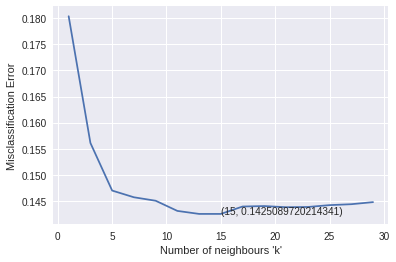

In [0]:
cv_scores = [] #list to keep cross validate score
for k in tqdm(klist):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree', n_jobs=-1)
    scores = cross_val_score(knn, tf_idf_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

#calculating Mssclassification error   
error = [1 - x for x in cv_scores]

#determing optimal k with least missclassification error value
optimal_k = klist[error.index(min(error))]
print(optimal_k)

#determing optimal k with least missclassification error value
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [0]:
#applying KNN on the optimal K calculated (15)

#initiate model
knn_kd_tf_idf = KNeighborsClassifier(n_neighbors= optimal_k, algorithm='kd_tree')

#fit model
knn_kd_tf_idf.fit(tf_idf_x_train, y_train)

#predicting values for test data
y_test_pred =  knn_kd_tf_idf.predict(tf_idf_x_test)

#calculating accuracy of model
train_acc = knn_kd_tf_idf.score(tf_idf_x_train, y_train)
train_error = 1 - train_acc
test_acc = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_acc

print("_" * 101)
print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)
print("_" * 101)


from sklearn.metrics import confusion_matrix

#evaluating confusion matrix for train and test
print("Train confusion matrix")
print(confusion_matrix(y_train, knn_kd_tf_idf.predict(tf_idf_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, knn_kd_tf_idf.predict(tf_idf_x_test)))

_____________________________________________________________________________________________________
Training Accuracy:  0.8644458226278019
Train Error:  0.1355541773721981
Test Accuracy:  0.8256402836058457
Test Error:  0.17435971639415426
_____________________________________________________________________________________________________
Train confusion matrix
[[  341  2998]
 [   62 19173]]
Test confusion matrix
[[  182  2347]
 [   63 11230]]


####Observation :
1. Optimal Hyperparaneter = 15
2. Training Accuracy = 86.44458226278019 %
3. Test Accuracy = 82.56402836058457 %

###5.3. KNN brute force on average W2V

In [0]:
#coveting text to vectors using avg w2v

#coveting train data to vectors using avg w2v
i=0
list_of_sent_train=[]
for sent in x_train:
    list_of_sent_train.append(sent.split())
    
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_x_train = Word2Vec(list_of_sent_train,min_count=5,size=50, workers=2)

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_x_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
avg_w2v_x_train = np.array(sent_vectors)
avg_w2v_x_train.shape

(22574, 50)

In [0]:
#coveting test data to vectors using avg w2v
i=0
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())
    
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_x_test = Word2Vec(list_of_sent_test,min_count=5,size=50, workers=2)

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_x_test.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
avg_w2v_x_test = np.array(sent_vectors)
avg_w2v_x_test.shape

(13822, 50)

In [0]:
#coveting cross validate data to vectors using w2v
i=0
list_of_sent_cv=[]
for sent in x_cv:
    list_of_sent_cv.append(sent.split())
    
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_x_cv = Word2Vec(list_of_sent_cv,min_count=5,size=50, workers=2)

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_x_cv.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
avg_w2v_x_cv = np.array(sent_vectors)
avg_w2v_x_cv.shape

(9675, 50)

100%|██████████| 15/15 [08:56<00:00, 37.48s/it]


21


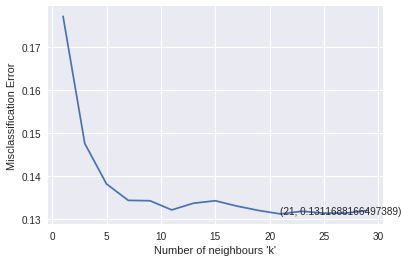

In [0]:
cv_scores = [] #list to keep cross validate score
for k in tqdm(klist):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree', n_jobs=-1)
    scores = cross_val_score(knn, avg_w2v_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
#calculating Mssclassification error  
error = [1 - x for x in cv_scores]

#determing optimal k with least missclassification error value
optimal_k = klist[error.index(min(error))]
print(optimal_k)

#determing optimal k with least missclassification error value
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [0]:
#applying KNN on the optimal K calculated (21)

#initiate model
knn_kd_avg_w2v = KNeighborsClassifier(n_neighbors= optimal_k, algorithm='kd_tree')

#fit model
knn_kd_avg_w2v.fit(avg_w2v_x_train, y_train)

#predicting values for test data
y_test_pred =  knn_kd_avg_w2v.predict(avg_w2v_x_test)

#calculating accuracy of model
train_acc = knn_kd_avg_w2v.score(avg_w2v_x_train, y_train)
train_error = 1 - train_acc
test_acc = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_acc

print("_" * 101)
print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)
print("_" * 101)


from sklearn.metrics import confusion_matrix

#evaluating confusion matrix for train and test
print("Train confusion matrix")
print(confusion_matrix(y_train, knn_kd_avg_w2v.predict(avg_w2v_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, knn_kd_avg_w2v.predict(avg_w2v_x_test)))

_____________________________________________________________________________________________________
Training Accuracy:  0.8768494728448658
Train Error:  0.12315052715513419
Test Accuracy:  0.8209376356533064
Test Error:  0.17906236434669365
_____________________________________________________________________________________________________
Train confusion matrix
[[  776  2563]
 [  217 19018]]
Test confusion matrix
[[  187  2342]
 [  133 11160]]


####Observation :
1. Optimal Hyperparaneter = 21
2. Training Accuracy = 87.68494728448658 %
3. Test Accuracy = 82.09376356533064 %

##6. Conclusion

In [0]:
!sudo pip3 install PTable

In [34]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Hyperparameter (K)", "Train Accuracy", "Test Accuracy"]

x.add_row(["BOW (Brute Force)", 9, 0.8673252414281917, 0.8215164230936188])
x.add_row(["TF-IDF (Brute Force)", 9, 0.8812793479223886, 0.8356243669512372])
x.add_row(["Average W2v (Brute Force)", 25, 0.8756091078231594, 0.8207205903631891])
x.add_row(["BOW (KD Tree)", 11, 0.8625409763444671, 0.8223122558240487])
x.add_row(["TF-IDF (KD Tree)", 15, 0.8644458226278019, 0.8256402836058457])
x.add_row(["Average W2v (KD Tree)", 21, 0.8768494728448658, 0.8768494728448658])

print(x)

+---------------------------+--------------------+--------------------+--------------------+
|           Model           | Hyperparameter (K) |   Train Accuracy   |   Test Accuracy    |
+---------------------------+--------------------+--------------------+--------------------+
|     BOW (Brute Force)     |         9          | 0.8673252414281917 | 0.8215164230936188 |
|    TF-IDF (Brute Force)   |         9          | 0.8812793479223886 | 0.8356243669512372 |
| Average W2v (Brute Force) |         25         | 0.8756091078231594 | 0.8207205903631891 |
|       BOW (KD Tree)       |         11         | 0.8625409763444671 | 0.8223122558240487 |
|      TF-IDF (KD Tree)     |         15         | 0.8644458226278019 | 0.8256402836058457 |
|   Average W2v (KD Tree)   |         21         | 0.8768494728448658 | 0.8768494728448658 |
+---------------------------+--------------------+--------------------+--------------------+


After the analysis of 50000 data points we conclude that the best model is when we apply **KNN Brute Force on TF-IDF** with

**Hyperparameter (K) = 9**

**Training Accuracy = 88.12793479223886%**

**Test Accuracy = 83.56243669512372%**